In [41]:
import os
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

In [42]:
from src.utils.general import get_db_conn, get_s3_credentials, load_triage_matrix_s3, load_model_s3
from src.utils import project_constants as constants

In [43]:
creds_folder = '../conf/local/'
fpath = os.path.join(creds_folder, 'credentials.yaml')
db_con = get_db_conn(fpath)
s3_creds = get_s3_credentials(fpath)

In [44]:
# experiment_hash = 'bb168764edcb5c27955514507eeb946f'
# mod_group = 70
# triage_folder = '/mnt/data/experiment_data/aclu/triage_tests/200805032817_baseline_a/'

# mod_group = 89
# experiment_hash = 'fe89e4ef1f23383dbae073bee962d850'
# triage_folder = '/mnt/data/experiment_data/aclu/triage_tests/200909044421_pa_first_p/'

# experiment_hash = '0d6c5365e65f1f93a94821e21a770999'
# mod_group = 9
# triage_folder = '/mnt/data/experiment_data/aclu/triage_tests/200805032817_baseline_a/'


# experiment_hash = '6e0363b6b29cc8f320b53bee954dfbf2'
# triage_folder = '/mnt/data/experiment_data/aclu/triage_tests/200918034525_pa_long_la/'

# experiment_hash = 'ffd0338febdc03e861b5d841408b0a62'
# triage_folder = 's3://aclu-leg-tracker/experiment_data/bill_passage/triage/pa_with_session_info3'

experiment_hash = '06e5c8c275e3ee4e11ca81d3ddf17c5e'
triage_folder = 's3://aclu-leg-tracker/experiment_data/bill_passage/national_model_test'

# experiment_hash = '858f2aefe25ed9b857b98f2d6d103dbe'
# triage_folder = 's3://aclu-leg-tracker/experiment_data/bill_passage/triage/pa_longest_label_window/'


#### Picking model group

In [45]:
# only considering random forests

q = """
    select 
        model_group_id,
        max(model_type) as model_type,
        max(hyperparameters ->> 'max_depth')::int as max_depth,
        max(hyperparameters ->> 'n_estimators')::int as n_estimators
    from triage_metadata.experiment_models join triage_metadata.models using(model_hash)
    where 
        experiment_hash='{}'
        and 
        model_type='sklearn.ensemble.RandomForestClassifier'
    group by
        model_group_id
""".format(experiment_hash)

In [46]:
model_groups = pd.read_sql(q, db_con)

In [100]:
# model_groups

In [101]:
# msk = (model_groups['max_depth'] == model_groups['max_depth'].max()) & (model_groups['n_estimators'] == model_groups['n_estimators'].max())
# model_groups[msk]

In [49]:
mod_group = 305

#### Get models, and matrices

In [50]:
q = """
        with models as (
            select 
                model_id, 
                model_hash, 
                model_type
            from triage_metadata.experiment_models join triage_metadata.models using(model_hash)
            where experiment_hash='{}' and model_group_id={}
        ),
        train_mats as (
            select 
                model_id,
                model_hash,
                model_type,
                matrix_uuid as train_mat
            from train_results.prediction_metadata join models using (model_id)
        ),
        test_mats as (
            select 
                model_id,
                matrix_uuid as test_mat
            from test_results.prediction_metadata join models using (model_id)
        )
        select 
            model_id,
            model_hash,
            -- model_type,
            train_mat,
            test_mat
        from train_mats join test_mats using (model_id)
        order by model_id
    """.format(experiment_hash, mod_group)

components = pd.read_sql(q, db_con)
components

,model_id,model_hash,train_mat,test_mat
0,7079,5c3f7798485474b42fce324a47a45df1,d725b163feef1b7ef129de6757772643,a32016719307c49b2f72e34907eb95b2
1,7080,0defb5f30a4ac27d5659fb09a9adeedf,c18c2c4db0f5813bc2543d633900abee,9414374ec1c9abe39a4b3cc88118e846
2,7081,3a1aac579dd6e7660e2ae356696beab0,ccbcca7523685752444501226822ace3,0c2987aed9eecab3a6b5d5692f8889fe
3,7082,5cf1a4817d7013b5d737d624c022ed48,a1530bcf8e575442f1c5f782c37156af,a90b2dba0f2bb7ec770b10553f742807
4,7083,ea8e50863d0902503654105f2aea6a2f,3a9d8ef234e94bb9074579d3aeb25918,6ca16bb12190a33363d2c362e934c00e


In [83]:
model_id = 7082

In [84]:
msk = components['model_id'] == model_id
model_hash= components[msk]['model_hash'].iloc[0]
test_uuid = components[msk]['test_mat'].iloc[0]

#### Precision

In [85]:
q = """
    select
        model_id,
        evaluation_start_time,
        evaluation_end_time,
        metric,
        parameter,
        num_labeled_examples,
        num_labeled_above_threshold,
        num_positive_labels,
        matrix_uuid,
        best_value,
        worst_value,
        stochastic_value
    from test_results.evaluations where model_id in {} and metric='precision@' order by "parameter";
""".format(tuple(components['model_id']))
eval_precision = pd.read_sql(q, db_con)


q = """
    select
        model_id,
        metric,
        parameter,
        num_labeled_examples,
        num_labeled_above_threshold,
        num_positive_labels,
        matrix_uuid,
        best_value,
        worst_value,
        stochastic_value
    from test_results.evaluations where model_id in {} and metric='recall@' order by "parameter";
""".format(tuple(components['model_id']))

eval_recall = pd.read_sql(q, db_con)

In [86]:
eval_precision['perc_points'] = [int(x.split('_')[0]) for x in eval_precision['parameter'].tolist()]
eval_recall['perc_points'] = [int(x.split('_')[0]) for x in eval_recall['parameter'].tolist()]

In [87]:
# msk = eval_precision['parameter']=='1_pct'
# eval_precision[msk].sort_values('evaluation_start_time')

#### PR-Curve

In [88]:
msk_prec = (eval_precision['model_id'] == model_id)
msk_rec = (eval_recall['model_id'] == model_id)

Text(0.5, 0, 'k%')

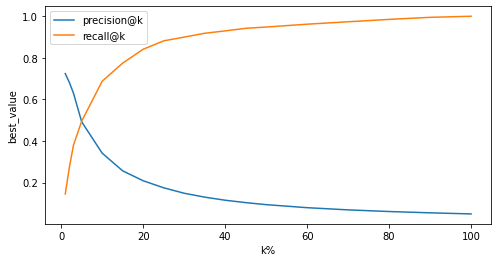

In [102]:
fig, ax = plt.subplots(figsize=(8,4))
sns.lineplot(x='perc_points', y='best_value', data=eval_precision[msk_prec], label='precision@k', ax=ax)
sns.lineplot(x='perc_points', y='best_value', data=eval_recall[msk_prec], label='recall@k', ax=ax)
ax.set_xlabel('k%')
# ax.set_title('Precision and Recall at k, model_id: {}, Test start time: {}'.format(model_id, eval_precision['evaluation_start_time'].iloc[0]))
# ax.set_title('Precision and Recall at k%: National')
# fig.savefig('meeting_figs/20200925_PR-K_pennsylvania_4week.png', bbox_inches='tight')
# plt.legend(loc=(90,0.6))

Text(0.5, 1.0, 'Precision and Recall at k%: National')

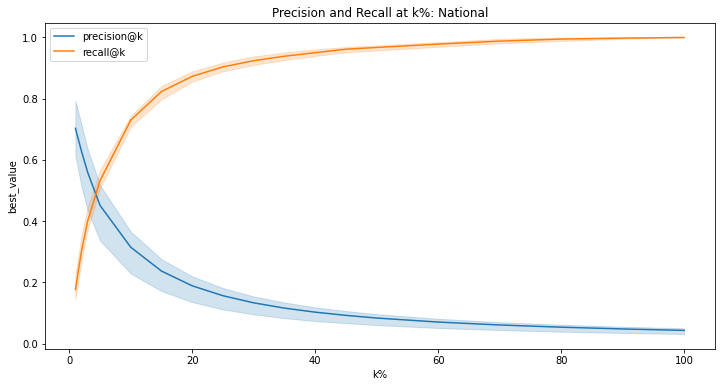

In [90]:
fig, ax = plt.subplots(figsize=(12,6))
sns.lineplot(x='perc_points', y='best_value', data=eval_precision, label='precision@k', ax=ax)
sns.lineplot(x='perc_points', y='best_value', data=eval_recall, label='recall@k', ax=ax)
ax.set_xlabel('k%')
# ax.set_title('Precision and Recall at k, model_id: {}, Test start time: {}'.format(model_id, eval_precision['evaluation_start_time'].iloc[0]))
ax.set_title('Precision and Recall at k%: National')
# fig.savefig('meeting_figs/20200925_PR-K_pennsylvania_4week.png', bbox_inches='tight')
# plt.legend(loc=(90,0.6))

### List inspection

In [91]:
q = """
    select 
        entity_id, as_of_date, score, label_value 
    from test_results.predictions where model_id={} order by score desc;
""".format(model_id)

In [92]:
model_predictions = pd.read_sql(q, db_con)
model_predictions = model_predictions.sort_values('score', ascending=False)

In [93]:
aods = list(model_predictions['as_of_date'].unique())

#### top-k for each test as_of_date

In [98]:
aod_precision = pd.DataFrame()
k = 1000
for aod in aods:
    d = dict()
    msk = (model_predictions['as_of_date'] == aod)
    temp = model_predictions[msk]
    num_ones_at_aod = temp['label_value'].value_counts().to_dict().get(1)
    if num_ones_at_aod is None:
        num_ones_at_aod = 0
    
    top_k = temp.iloc[:k]
    label_dist = top_k['label_value'].value_counts().to_dict()
    num_ones_top_k = label_dist.get(1)
    if num_ones_top_k is None:
        num_ones_top_k = 0
        
    d['as_of_date'] = aod
    d['precision_at_{}'.format(k)] = num_ones_top_k/k
    
    if num_ones_at_aod > 0: 
        d['recall_at_{}'.format(k)] = num_ones_top_k/num_ones_at_aod
    else:
        d['recall_at_{}'.format(k)] = 0
        
    d['prevalence'] = num_ones_at_aod/temp.shape[0]
    d['max_score'] = top_k['score'].max()
    d['num_ones_aod'] = num_ones_at_aod
    
    aod_precision = aod_precision.append(d, ignore_index=True)
    

Text(0, 0.5, 'Number of ones')

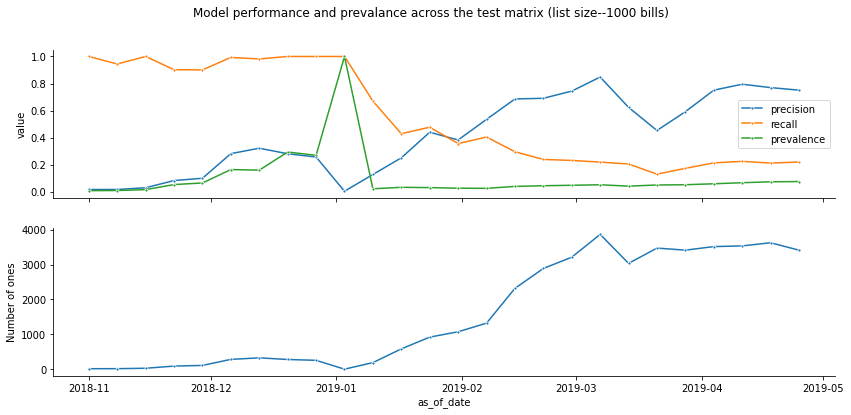

In [99]:
fig, axes = plt.subplots(2, 1, figsize=(14, 6), sharex=True)

sns.lineplot(data=aod_precision, x='as_of_date', y='precision_at_{}'.format(k), marker='.', label='precision', ax=axes[0])
sns.lineplot(data=aod_precision, x='as_of_date', y='recall_at_{}'.format(k), marker='.', label='recall', ax=axes[0])
sns.lineplot(data=aod_precision, x='as_of_date', y='prevalence', marker='.', label='prevalence', ax=axes[0])
sns.lineplot(data=aod_precision, x='as_of_date', y='num_ones_aod', marker='.', ax=axes[1])

fig.suptitle('Model performance and prevalance across the test matrix (list size--{} bills)'.format(k))

axes[0].legend()
axes[0].spines['right'].set_visible(False)
axes[0].spines['top'].set_visible(False)

axes[1].spines['right'].set_visible(False)
axes[1].spines['top'].set_visible(False)

axes[0].set_ylabel('value')
axes[1].set_ylabel('Number of ones')
# plt.tight_layout()

In [96]:
aod_precision['prevalence'].max()

1.0

In [97]:
aod_precision['prevalence'].mean()

0.10702667123925602

### List stability

Checking the overlap of bills between two sequntial as_of_dates

In [103]:
# aod_precision = pd.DataFrame()
top_k_intersection = pd.DataFrame()
intersections= list()
for i,aod in enumerate(aods):
    d = dict()
    msk = (model_predictions['as_of_date'] == aod)
    temp = model_predictions[msk]
    top_k = temp.iloc[:k]
    d['as_of_date'] = aod
    d['top_k_bills'] = set(top_k['entity_id'])
    d['intersection_with_previous'] = 0
    if i> 0:
        temp = d['top_k_bills'].intersection(intersections[i-1]['top_k_bills'])
        d['intersection_with_previous'] = len(temp)/k
        
    intersections.append(d)
    top_k_intersection = top_k_intersection.append(d, ignore_index=True)

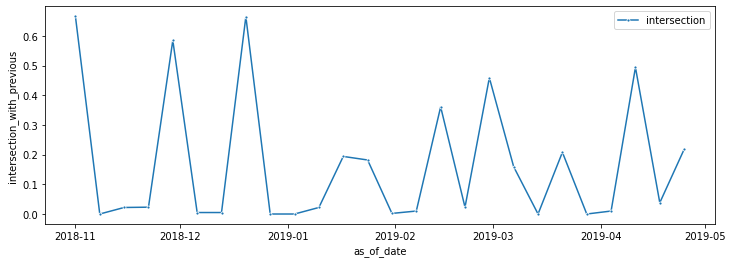

In [104]:
# top_k_intersection
fig, axes = plt.subplots(figsize=(12, 4))

sns.lineplot(data=top_k_intersection, x='as_of_date', y='intersection_with_previous'.format(k), marker='.', label='intersection', ax=axes)

In [29]:
# intrsctions = list()
# for i, b in enumerate(bills_in_topk):
#     if i > 0:
#         intrsctions.append(b.intersection(bills_in_topk[i-1]))

In [31]:
intersection_sizes = [len(x)/k for x in intrsctions]

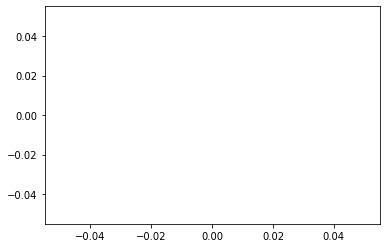

In [32]:
plt.plot(intersection_sizes)

#### Score vs as_of_date

In [30]:
scores_with_time = model_predictions.groupby('as_of_date').max().reset_index()[['score', 'as_of_date']]

In [39]:
# scores_with_time.head()

In [40]:
# scores_with_time.plot()

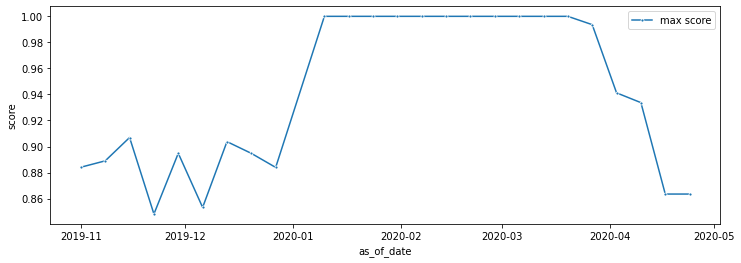

In [31]:
fig, axes = plt.subplots(figsize=(12, 4))

sns.lineplot(data=scores_with_time, x='as_of_date', y='score'.format(k), marker='.', label='max score', ax=axes)

### Feature importances

In [105]:
import joblib
import boto3
import tempfile
from io import BytesIO

In [106]:
session = boto3.Session(
    aws_access_key_id=s3_creds['aws_access_key_id'],
    aws_secret_access_key=s3_creds['aws_secret_access_key']
)

s3 = session.resource('s3')
s3_bucket = constants.S3_BUCKET

#### When store is on S3

In [107]:
models_folder = '{}/{}'.format(triage_folder, 'trained_models')
matrices_folder = '{}/{}'.format(triage_folder, 'matrices')

In [109]:
model_key = '{}/{}'.format(models_folder, model_hash)

mod_obj = load_model_s3(session, model_key)

In [110]:
mat_key = '{}/{}.csv.gz'.format(matrices_folder, test_uuid)
test_mat = load_triage_matrix_s3(session, mat_key)

### When store is on the disk

In [216]:
models_folder = os.path.join(triage_folder, 'trained_models')
mod_obj = joblib.load(os.path.join(models_folder, model_hash))

In [242]:
matrices_folder = os.path.join(triage_folder, 'matrices')
test_mat = pd.read_csv(os.path.join(matrices_folder, test_uuid+'.csv.gz'))

In [1]:
test_mat.shape

NameError: name 'test_mat' is not defined

In [236]:
# test_mat = test_mat.set_index(['entity_id', 'as_of_date'])

### Feature importances

In [114]:
# feat = [x for x in test_mat.set_index(['entity_id', 'as_of_date']).columns if 'passed_1mon'  not in x]
feat = [x for x in test_mat.columns if 'passed_1mon'  not in x]

In [116]:
importances = pd.Series(mod_obj.feature_importances_, index=feat)

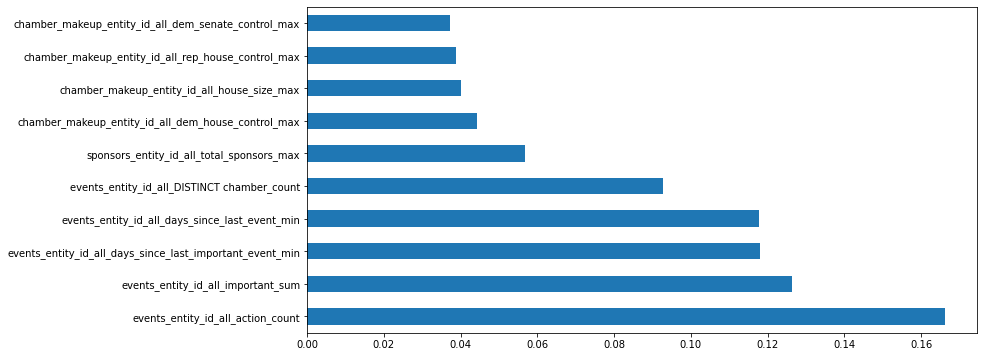

In [117]:
fig, ax = plt.subplots(figsize=(12,6))
importances.sort_values(ascending=False).iloc[:10].plot(kind='barh', ax=ax)

In [22]:
top_features = list(importances.sort_values(ascending=False).iloc[:10].index)
top_features

['events_entity_id_all_action_count',
 'events_entity_id_all_important_sum',
 'events_entity_id_all_days_since_last_event_min',
 'events_entity_id_all_days_since_last_important_event_min',
 'events_entity_id_all_DISTINCT chamber_count',
 'sponsors_entity_id_all_total_sponsors_max',
 'chamber_makeup_entity_id_all_dem_house_control_max',
 'chamber_makeup_entity_id_all_house_size_max',
 'chamber_makeup_entity_id_all_dem_senate_control_max',
 'chamber_makeup_entity_id_all_rep_house_control_max']

### Feature inspection

In [43]:
model_predictions['as_of_date'] = model_predictions['as_of_date'].dt.strftime('%Y-%m-%d')

In [44]:
merged = test_mat.merge(model_predictions, on=['entity_id', 'as_of_date'])

In [48]:
# feature = 'session_info_entity_id_all_remaining_time_max'
feature = top_features[0]

Text(0.5, 1.0, 'The model score against the feature--events_entity_id_all_action_count')

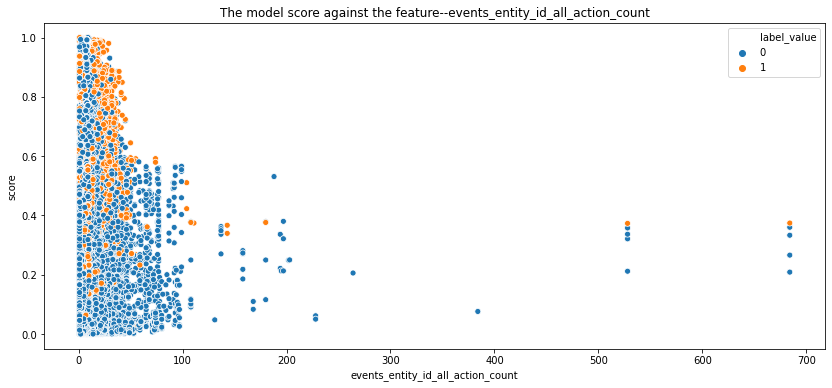

In [49]:
fig, ax = plt.subplots(figsize=(14,6))
sns.scatterplot(data=merged, x=feature, y='score', ax=ax, hue='label_value')
# plt.xticks(rotation=70)
plt.title('The model score against the feature--{}'.format(feature))

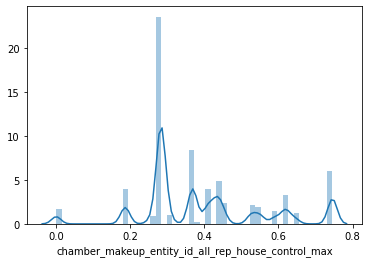

In [47]:
sns.distplot(merged[feature])

In [84]:
cut_off = 0.6


In [85]:
msk = (merged['score'] >= cut_off)

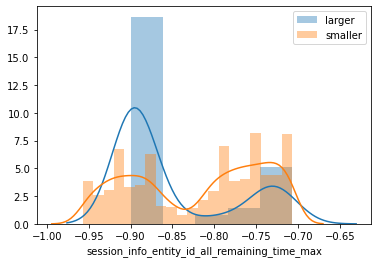

In [86]:
sns.distplot(merged[msk][feature], kde=True, label='larger')
sns.distplot(merged[~msk][feature], kde=True, label='smaller')
plt.legend()

In [170]:
mat_hash = components[components['model_id']==model_id]['test_mat'].iloc[0]

In [171]:
test_mat = pd.read_csv(os.path.join(matrices_folder, '{}.csv.gz'.format(mat_hash)))

In [2]:
# list(test_mat.columns)

In [100]:
test_mat['as_of_date'].min()

'2011-04-01'

In [101]:
test_mat['as_of_date'].max()

'2011-09-01'

In [103]:
test_mat['as_of_date'].unique()

array(['2011-04-01', '2011-05-01', '2011-06-01', '2011-07-01',
       '2011-08-01', '2011-09-01'], dtype=object)

In [105]:
test_mat.shape[0]

542578

In [107]:
test_mat.groupby('bill_passage').count()['entity_id']

bill_passage
0.0    512543
1.0     30035
Name: entity_id, dtype: int64